# References

The following notebook generates coded examples, with some accompanying theory, of some of the statistical methods discussed in the following works:

Bishop, C.M., 2006. Pattern recognition and machine learning. springer.

Rasmussen, C.E. and Williams, C.K., 2006. Gaussian processes for machine learning, MIT press.

Sollich, P., 2004. Can Gaussian process regression be made robust against model mismatch?. In International Workshop on Deterministic and Statistical Methods in Machine Learning (pp. 199-210). Springer, Berlin, Heidelberg.

Stegle, O., Lippert, C., Mooij, J.M., Larence, N.D. and Borgwardt, K., 2011. Efficient inference in matrix-variate Gaussian models with iid observation noise.

Rakitsch, B., Lippert, C., Borgwardt, K. and Stegle, O., 2013, December. It is all in the noise: Efficient multi-task Gaussian process inference with structured residuals. In Proceedings of the 26th International Conference on Neural Information Processing Systems-Volume 1 (pp. 1466-1474).

# Curve Fitting

The cell below is code based on pages 6-9 of Bishop, 2006.

Given a set of observation pairs (x,y), we would like to identify the underlying regularity, or function, from which the data were created. For example, we can formulate a generic model which says that our observations y are generated from some function f(x) such that this function performs a mapping of the inputs x, to the ouputs y. i.e: y = f(x). We then presume that the outputs have been corrupted by some small amount of random noise such that y = f(x) + noise.
Regression analysis is a way to learn about the function f(x), where the goal is to replicate the 'unknown' function as closely as possible without over-fitting (i.e making the regression model pass through all the data points such that we are fitting the random noise as well). We shall also see below how sometimes we need relatively complex models in order to learn relatively complex (non-linear) functions.

True regression weights: -0.3 0.6
Regression weights from numerical optimisation: -0.339 0.644
Regression weights from analytical solution: -0.339 0.644


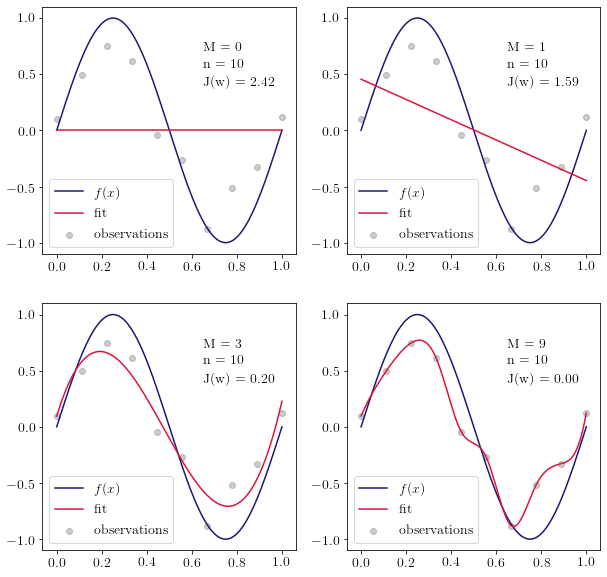

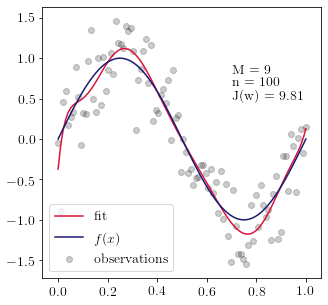

In [12]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

#let's start by drawing some data from a linear function f(x). In reality we don't know the parameters of this
#function, but they are what we want to learn.
def f(x):
    return w0 + x*w1 #a 1D linear function has 2 terms: the bias term w0, and the gradient term w1.

n = 10 #number of observations
sn2 = 0.3 #noise variance
w0 = -0.3 #true 'unknown' parameter
w1 = 0.6 #true 'unknown' parameter
x = np.linspace(0,1,n)
y = f(x) + np.random.normal(0,sn2,n)

#In order to retrieve the parameters w0,w1 we typically try to minimise some cost function which minimises the
#misfit between the outputs y, and the function value x^Tw, for a given value of w:

def J(w): #cost function: sum of the square of the residuals
    Jw = y.T.dot(y)/2 - mdot([w.T,x.T,y]) + mdot([w.T,x.T,x,w])/2 #expanded form of (y - x^Tw)^2
    dJdw = -x.T.dot(y) + mdot([x.T,x,w]) #gradient of the cost function with respect to w
    return Jw,dJdw

#Here we can see that the solution for the gradient of the cost function dJdw is linear with respect to w, so then
#J(w) must have a unique solution. We can see this by first setting dJwdw to zero, at which point we arrive at the
#normal equation for least squares regression: mdot([x.T,x,w])==x.T.dot(y). If the inverse (x.T.dot(x))^-1
#exists, then we can simply multiply both sides of the normal equation by this inverse to get:
#mdot([np.linalg.inv(x.T.dot(x)),x.T,x,w])==mdot([np.linalg.inv(x.T.dot(x)),x.T,y]), and because a matrix times its
#inverse equals identity, this simplifies to the optimal solution for least squares regression: 
#w = mdot([np.linalg.inv(x.T.dot(x)),x.T,y])

#Let's check this is consistent by using an optimisation algorithm to compute w and also computing w in closed 
#form:
x = np.array([np.ones(n),x]).T #augment input vector x with vector of ones to account for bias term w0
w_opt = minimize.run(J,X=np.zeros(2),length=200)

L = np.linalg.cholesky(np.dot(x.T,x)) #cholesky decomp is a faster & more stable way of getting a matrix inverse
w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(x.T,y)))
print('True regression weights:',w0,w1)
print('Regression weights from numerical optimisation:','%.3f'%w_opt[0],'%.3f'%w_opt[1])
print('Regression weights from analytical solution:','%.3f'%w_closed_form[0],'%.3f'%w_closed_form[1])

#Now let's try the same exercise but attempting to fit a non-linear function with a series of different polynomial
#fits, where we use the closed form expression for the regression weights from here on:

def f(x):
    return np.sin(2*np.pi*x)

def fit(X):
    L = np.linalg.cholesky(np.dot(X.T,X)) 
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

n = 10 #number of observations
sn2 = 0.3 #noise variance
x = np.linspace(0,1,n)
fx = f(x)
y = fx + np.random.normal(0,sn2,n)
ys = np.zeros((n,4))
Jw = np.zeros(4)

ys[:,0],Jw[0] = fit(np.ones(n).reshape(n,1)) #M = 0, i.e. the order of the polynomial fit.
ys[:,1],Jw[1] = fit(np.array([np.ones(n),x]).T) #M = 1
ys[:,2],Jw[2] = fit(np.array([np.ones(n),x,x**2,x**3]).T) #M = 3
ys[:,3],Jw[3] = fit(np.array([np.ones(n),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T) #M = 9

x_smooth = np.linspace(x.min(),x.max(),200)
fx_smooth = f(x_smooth)
y_smooth = np.zeros((200,4))
for c in range(4):
    y_smooth[:,c] = spline(x,ys[:,c],x_smooth)

M = [0,1,3,9] #these correspond to the number of polynomial basis functions (see the code on Basis functions below)
fig,ax = plt.subplots(2,2,figsize=(10,10))
axes = [[0,0],[0,1],[1,0],[1,1]]
for c in range(4):
    ax[axes[c][0],axes[c][1]].scatter(x,y,color='k',alpha=0.2, label='observations')
    ax[axes[c][0],axes[c][1]].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
    ax[axes[c][0],axes[c][1]].plot(x_smooth,y_smooth[:,c],color='crimson',label='fit')
    ax[axes[c][0],axes[c][1]].text(0.65,0.7,'M = '+str(M[c]))
    ax[axes[c][0],axes[c][1]].text(0.65,0.55,'n = '+str(n))
    ax[axes[c][0],axes[c][1]].text(0.65,0.40,'J(w) = '+str('%.2f' % Jw[c]))
    ax[axes[c][0],axes[c][1]].legend(loc='lower left')
plt.show()

#We can see that for the scenario where M = 0, or M = 1, the model is under-fitting the function f(x). For M = 9 it
#is dramatically overfitting, and passes through each training point so J(w) = 0.
#Now let's plot the same function but increase the number of training points from 10 to 100:

n = 100 #number of observations
x = np.linspace(0,1,n)
fx = f(x)
y = fx + np.random.normal(0,sn2,n)
X = np.array([np.ones(n),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T
fig,ax = plt.subplots(1,figsize=(5,5))
plt.plot(x,fit(X)[0],color='crimson',label='fit')
plt.scatter(x,y,color='k',alpha=0.2,label='observations')
plt.plot(x,fx,color='midnightblue',label='$f(x)$')
plt.text(0.7,0.8,'M = 9')
plt.text(0.7,0.65,'n = '+str(n))
plt.text(0.7,0.50,'J(w) = '+str('%.2f' % fit(X)[1]))
plt.legend(loc='lower left')
plt.show()



# Regularisation

The cell below is code based on pages 10-11 of Bishop, 2006.

Regularisation aims to control over-fitting (fitting a model to noise, e.g. M=9,n=10 in the plots above) by introducing a penalty term to the least squares error function, such that: J(w) = || y - x^Tw ||^2 + λ||w||^q. λ is the regularisation coefficient and controls the relative importance of the two terms in J(w) above. if q == 1 (L1 norm - diamond penalty zone) then this is known as 'Lasso' regression, and if q == 2 (L2 norm - circular penalty zone) then it is the quadratic regulariser known as 'Ridge' regression. If λ is sufficiently large then some of the coefficients in w are driven to zero in Lasso, or near zero in Ridge, leading to a sparse model in which the corresponding basis functions play no role.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


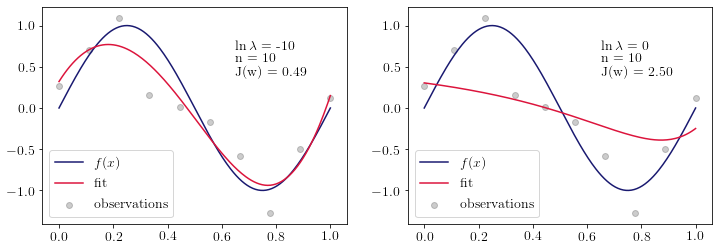

In [3]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X,λ): #ridge regression (note that Lasso does not have an equivalent closed form expression)
    L = np.linalg.cholesky(np.dot(X.T,X) + λ*np.eye(X.shape[1])) 
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

n = 10 #number of observations
sn2 = 0.3 #noise variance
x = np.linspace(0,1,n)
fx = f(x)
y = fx + np.random.normal(0,sn2,n)
ys = np.zeros((n,2))
Jw = np.zeros(2)

ys[:,0],Jw[0] = fit(np.array([np.ones(n),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T,λ=np.exp(-10))
ys[:,1],Jw[1] = fit(np.array([np.ones(n),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T,λ=np.exp(0))

x_smooth = np.linspace(x.min(),x.max(),200)
fx_smooth = f(x_smooth)
y_smooth = np.zeros((200,2))
for c in range(2):
    y_smooth[:,c] = spline(x,ys[:,c],x_smooth)

fig,ax = plt.subplots(1,2,figsize=(12,4))
λs = [-10,0]
for c in range(2):
    ax[c].scatter(x,y,color='k',alpha=0.2,label='observations')
    ax[c].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
    ax[c].plot(x_smooth,y_smooth[:,c],color='crimson',label='fit')
    ax[c].text(0.65,0.7,'$\ln\lambda$ = '+str(λs[c]))
    ax[c].text(0.65,0.55,'n = '+str(n))
    ax[c].text(0.65,0.40,'J(w) = '+str('%.2f' % Jw[c]))
    ax[c].legend(loc='lower left')
plt.show()


# Basis Functions

The code below is based on pages 138-140 of Bishop,2006 or pages 11-12 of R&W.

Basis functions are a way to overcome the limitations of a linear model x^Tw by projecting the inputs into some high dimensional feature space, and then applying the same linear equations there, rather than directly on the inputs themselves. As long as the projections are fixed functions, the model is still linear in the parameters and so analytically tractable. Therefore by using non-linear basis functions we can capture non-linear relationships in f(x)... such as sin(2πx)

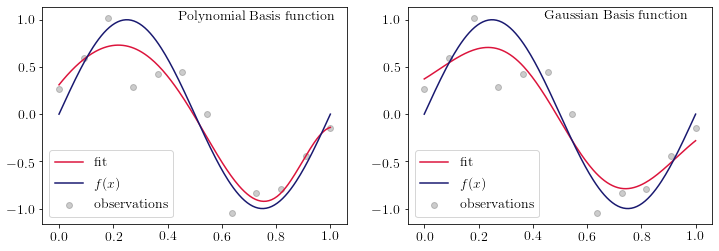

In [30]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X,λ):
    L = np.linalg.cholesky(np.dot(X.T,X) + λ*np.eye(X.shape[1]))
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

n = 12 #number of observations
sn2 = 0.3 #noise variance
x = np.linspace(0,1,n)
x_smooth = np.linspace(x.min(),x.max(),200)
fx = f(x)
fx_smooth = f(x_smooth)
y = fx + np.random.normal(0,sn2,n)

#we have already seen examples of Basis functions in the code above (on curve fitting and regularisation).
#for example:

ϕ = np.array([np.ones(n),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T
yPoly = spline(x,fit(ϕ,λ=np.exp(-10))[0],x_smooth)
#here we project the scalar input x into a space of powers, so ϕ becomes a polynomial basis function.
#this enabled us to fit a model to a sine function, despite using a linear model x^Tw.

#Alternatively we could project the input into a series of M Gaussian basis functions:
M = 30
ell = 0.2
ϕ = np.zeros((n,M+1))
ϕ[:,0] = np.ones(n)
mu = np.random.rand(M)
for m in range(M):
    ϕ[:,m+1] = np.exp(-(x-mu[m])**2/(2*(ell**2)))
yGauss = spline(x,fit(ϕ,λ=np.exp(-0.31))[0],x_smooth)

fig,ax = plt.subplots(1,2,figsize=(12,4))
data = [yPoly,yGauss] ; captions = ['Polynomial','Gaussian']
for c in range(2):
    ax[c].scatter(x,y,color='k',alpha=0.2,label='observations')
    ax[c].plot(x_smooth,data[c],color='crimson',label='fit')
    ax[c].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
    ax[c].text(0.44,1,captions[c]+' Basis function')
    ax[c].legend(loc='lower left')
plt.show()


# Maximum Likelihood and Bias

The cell below is code based on pages 26-30 of Bishop, 2006.

We show maximum likelihood can be a way to recover the parameters of a distribution given enough samples. And how maximum likelihood is equivalent to minimizing the sum of the squares in the context of curve fitting with a Gaussian noise distribution.

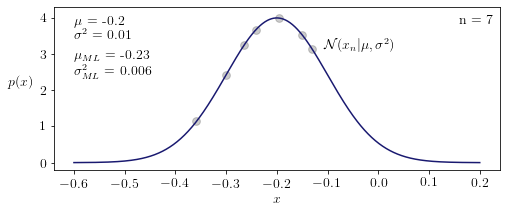

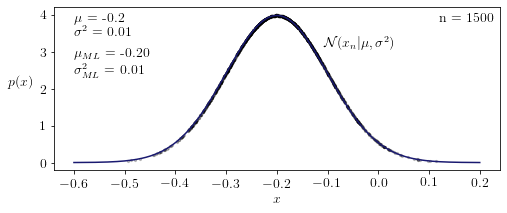

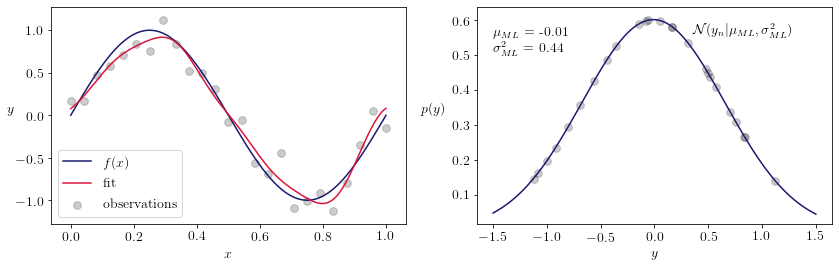

In [6]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(4)

#draw data samples from an 'unknown' normal distribution
n = 7
mu_true = -0.2
var_true = 0.01
sd_true = var_true**0.5
x = np.random.normal(mu_true,sd_true,n)
px = 1/(np.sqrt(2*np.pi)*sd_true)*np.exp(-.5*((x-mu_true)/sd_true)**2) #likelihood of observation samples
px_true = 1/(np.sqrt(2*np.pi)*sd_true)*np.exp(-.5*((np.linspace(-.6,.2,1000)-mu_true)/sd_true)**2) #true likelihood

#now we want to recover mu_true and var_true from the data by maximising (minimising) the 
#(negative) log likelihood function:

def negloglike(parameters): #eq 1.54 Bishop,2006
    mu = parameters[0] ; var = np.exp(parameters[1])
    nl = 1/(2*var) * np.sum((x - mu)**2) + .5*n*np.log(var) + .5*n*np.log(2*np.pi)
    dnl = np.array([1/(2*var) * np.sum(-2*(x - mu)),-((var**-2)/2)*np.sum((x - mu)**2) + .5*n*(1/var)])
    return nl,dnl

#Because the logarithm is a monotonically increasing function of its argument, maximisation of the log of a
#function is equivalent to maximisation of the function itself. Minimising negloglike with respect to mu gives:
mu_ML = np.mean(x) #eq 1.55 Bishop,2006
#and similarly minimising with respect to the variance gives:
var_ML = np.mean((x-mu_ML)**2) #eq 1.56 Bishop,2006
#see how the above is equivalent to using a optimisation algorithm:
#param_opt = scipy.optimize.minimize(negloglike,x0=[0,np.log(0.1)],args=(x))
param_opt = minimize.run(negloglike,X=[0,np.log(0.1)],length=200)
#print(mu_ML,var_ML)
mu_ML_opt = param_opt[0]
var_ML_opt = np.exp(param_opt[1])
#print(mu_ML_opt,var_ML_opt)
#mu_ML ~ mu_ML_opt ; var_ML ~ var_ML_opt

fig,ax = plt.subplots(1,figsize=(8,3))
plt.plot(np.linspace(-.6,.2,1000),px_true,color='midnightblue')
plt.scatter(x,px,color='k',alpha=0.2,s=60)
plt.xlabel('$x$')
plt.ylabel('$p(x)$',rotation=0,labelpad=20)
plt.text(-0.11,3.1,'$\mathcal{N}(x_n|\mu,\sigma^2)$')
plt.text(-0.6,3.8,'$\mu$ = '+str(mu_true))
plt.text(-0.6,3.4,'$\sigma^2$ = '+str(var_true))
plt.text(-0.6,2.8,'$\mu_{ML}$ = '+str('%.2f'%mu_ML))
plt.text(-0.6,2.3,'$\sigma^2_{ML}$ = '+str('%.3f'%var_ML))
plt.text(0.16,3.8,'n = '+str(n))
plt.show()

#we can see how the variance is under-estimated with maximum likelihood because the variance is measured
#relative to the sample mean and not the true mean. This is known as bias. Also, in this case due to the small
#number of samples the mean over-estimated

#let's consider more observations and see how our estimate of the mean and variance changes:
n = 1500
x = np.random.normal(mu_true,sd_true,n)
px = 1/(np.sqrt(2*np.pi)*sd_true)*np.exp(-.5*((x-mu_true)/sd_true)**2)
mu_ML = np.mean(x)
var_ML = np.mean((x-mu_ML)**2)

fig,ax = plt.subplots(1,figsize=(8,3))
plt.plot(np.linspace(-.6,.2,1000),px_true,color='midnightblue')
plt.scatter(x,px,color='k',alpha=0.2,s=5)
plt.xlabel('$x$')
plt.ylabel('$p(x)$',rotation=0,labelpad=20)
plt.text(-0.11,3.1,'$\mathcal{N}(x_n|\mu,\sigma^2)$')
plt.text(-0.6,3.8,'$\mu$ = '+str(mu_true))
plt.text(-0.6,3.4,'$\sigma^2$ = '+str(var_true))
plt.text(-0.6,2.8,'$\mu_{ML}$ = '+str('%.2f'%mu_ML))
plt.text(-0.6,2.3,'$\sigma^2_{ML}$ = '+str('%.2f'%var_ML))
plt.text(0.12,3.8,'n = '+str(n))
plt.show()

#with enough observations ML, on average, will obtain the correct mean of the distribution, 
#as well as the true variance. For small N, ML under-estimates the true variance by a factor (N-1)/N.

#CURVE FITTING RE-VISITED
#Now let's return to a curve fitting example under the assumption of a Gaussian noise distribution, such that
#for a given value of x; the corresponding value of y has a Gaussian distribution with mean equal to f(x,w)
#and variance equal to sn2.

#Substituting for the form of a Gaussian distribution, we obtain the (negative) log likelihood function as:
def negloglike(parameters,x,y): #eq 1.62 Bishop,2006
    var = np.exp(parameters[0]) ; w = parameters[1:]
    return 1/(2*var) * np.dot((y - np.dot(x,w)).T,(y - np.dot(x,w))) - .5*n*np.log(1/(var)) + .5*n*np.log(2*np.pi)
    
#minimising the expression above with respect to the regression parameters w, means we can neglect the last 2 terms
#as they do not depend on w. Also the positive scaling consant 1/(2*var) does not alter the location of the minimum
#at which point we can see that minimisation of the negative log likelihood is equivalent to minimising the sum of
#the squares error function: 1/2 * np.dot((y - np.dot(x,w)).T,(y - np.dot(x,w))). We can therefore use ML 
#(least-squares) to estimate the mean (w_ML) and variance (var_ML) of the likelihood distribution. Let's try an
#example using the model of y = f(x) + noise, where f(x) = sin(2*np.pi*x):

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X):
    L = np.linalg.cholesky(np.dot(X.T,X))
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

n = 25 #number of observations
M = 8 #number of basis functions
ell = 0.1 #length scale of Gaussian basis function
sn2 = 0.2 #variance
x = np.linspace(0,1,n)
x_smooth = np.linspace(0,1,200)
fx = f(x)
fx_smooth = f(x_smooth)
y = fx + np.random.normal(0,sn2,n)
ϕ = np.zeros((n,M+1))
ϕ[:,0] = np.ones(n)
mu = np.random.rand(M)
for m in range(M):
    ϕ[:,m+1] = np.exp(-(x-mu[m])**2/(2*(ell**2))) #Gaussian basis function

#the mean of our fit then equates to the mean of the likelihood distribution:
mu_ML = np.mean(fit(ϕ)[0])
#and also the variance:
var_ML = (fit(ϕ)[1])
sd_ML = var_ML**.5
py = 1/(np.sqrt(2*np.pi)*sd_ML)*np.exp(-.5*((y-mu_ML)/sd_ML)**2) #likelihood distribution
py_ML = 1/(np.sqrt(2*np.pi)*sd_ML)*np.exp(-.5*((np.linspace(-1.5,1.5,200)-mu_ML)/sd_ML)**2) 

fig,ax = plt.subplots(1,2,figsize=(14,4))
for c in range(2):
    if c == 0:
        ax[c].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
        ax[c].scatter(x,y,color='k',alpha=0.2,s=60,label='observations')
        ax[c].plot(x_smooth,spline(x,fit(ϕ)[0],x_smooth),color='crimson',label='fit')
        ax[c].set_xlabel('$x$')
        ax[c].set_ylabel('$y$',rotation=0,labelpad=5)
        ax[c].legend(loc='lower left')
    if c == 1:
        ax[c].plot(np.linspace(-1.5,1.5,200),py_ML,color='midnightblue')
        ax[c].scatter(y,py,color='k',alpha=0.2,s=60)
        ax[c].set_xlabel('$y$')
        ax[c].set_ylabel('$p(y)$',rotation=0,labelpad=20)
        ax[c].text(0.35,0.55,'$\mathcal{N}(y_n|\mu_{ML},\sigma^2_{ML})$')
        plt.text(-1.5,.55,'$\mu_{ML}$ = '+str('%.2f'%mu_ML))
        plt.text(-1.5,.5,'$\sigma^2_{ML}$ = '+str('%.2f'%var_ML))
plt.show()

#then for new values for x we can make predictions of of y with uncertainty as we have a probabilistic model.
#we simply evaluate the value of y based on the new value of x using our learnt function. and then generate a
#distribution using the maximum likelihood values of the mean and variance which we learnt earlier.

# Bias-Variance tradeoff

The cell below is code based on pages 149 - 151 of Bishop, 2006.

As we have seen above, sometimes we need a relatively complex model (e.g high number of basis functions) to accurately fit a complex (i.e non-linear) model. However, how do we choose the right number of basis functions without over- or under-fitting? We have also seen that regularisation is a way to overcome over-fitting problems, however trying to derive the optimal values of both w and λ which minimise the error function (or maximise the likelihood) is not suitable as this just leads to λ = 0. Over-fitting is really just an unfortunate property of maximum likelihood methods. Here we show some examples of the inherent struggle of frequentist model fitting exercises, where we must reach a tradeoff between accurately estimating the function from which our observations were generated (i.e a low bias), and achieving a consistently similar model between data sets (low variance).
Think of it like bias = accuracy and variance = precision.

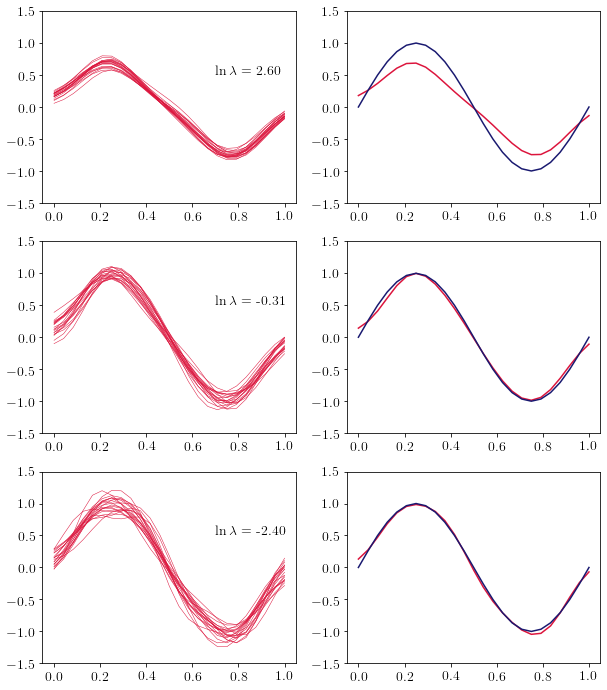

In [6]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function
    return np.sin(2*np.pi*x)

#here we draw 20 i.i.d different data sets, each with 25 observations, from the same function sin(2pix) + noise.
#the aim is to use these data sets to estimate the 'unknown' function sin(2pix) using regression.
#Here we generate 3 different models in attempt to best fit this function. Each model is constructed using 24 Gaussian
#basis functions, and ridge regression is performed for the fitting. The difference is that each of the three models
#uses a different regularisation coefficient λ

n = 25 #number of observations
M = 24 #number of basis functions
D = 20 #number of data sets
s = 0.1 #length scale of Gaussian basis function
sn2 = 0.2 #noise variance
λs = [np.exp(2.6),np.exp(-0.31),np.exp(-2.4)]
x = np.linspace(0,1,n)
fx = f(x)
ϕ = np.zeros((n,M+1))
ϕ[:,0] = np.ones(n)
mu = np.random.rand(M)
for m in range(M):
    ϕ[:,m+1] = np.exp(-(x-mu[m])**2/(2*(s**2))) #Gaussian basis function
ys = np.zeros((len(λs),D,n))
count = 0
for λ in λs:
    L = np.linalg.cholesky(np.dot(ϕ.T,ϕ) + λ*np.eye(ϕ.shape[1]))
    for d in range(D):
        y = f(x) + np.random.normal(0,sn2,n)
        w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ.T,y)))
        ys[count,d,:] = np.dot(w,ϕ.T)
    count += 1

fig,ax = plt.subplots(3,2,figsize=(10,12))
for ix in range(3):
    for jx in range(2):
        if jx == 0:
            ax[ix,jx].plot(x,ys[ix,:,:].T,color='crimson',lw=.5)
            ax[ix,jx].set_ylim(-1.5,1.5)
            ax[ix,jx].text(0.7,0.5,'$\ln\lambda$ = '+str('%.2f' % np.log(λs[ix])))
        else:
            ax[ix,jx].plot(x,np.mean(ys[ix,:,:],axis=0),color='crimson')
            ax[ix,jx].plot(x,fx,color='midnightblue')
            ax[ix,jx].set_ylim(-1.5,1.5)
plt.show()

#the plots on the left show the fits for each of the 20 different data sets, for each of the 3 models. We can see
#that where lnλ = 2.6, the models are relatively well grouped (similar). i.e they have low VARIANCE, whereas the
#model with lnλ = -0.31 and lnλ = -2.4 show increasing amounts of variance between fits. 
#The plots on the right then show the average of each of the corresponding model fits for all 20 data sets. Here we
#can see that while lnλ = 2.6 has low VARIANCE it has the highest BIAS as it does not accurately estimate the data
#generating function (blue). Whereas the model with the largest VARIANCE (lnλ = -2.4) shows the lowest
#BIAS, in that the average of all the fits accurately respresents sin(2pix).

#N.B "Although the bias-variance decomposition may provide some interesting insights into the model complexity issue
#from a frequentist perspective, it is of limited practical value, because the bias-variance decomposition is based
#on averages with respect to ensembles of data sets, whereas in practice we have only the single observed data set."


# Model Selection (Cross-Validation)

We have seen in the context of curve fitting using least squares that there was an optimal order of the polynomial basis function M that gave the best fit, and with regularised least squares there was an optimal value for λ which gave the best fit. The order of the polynomial controls the number of free parameters in the model and therefore governs the model complexity, and similarly λ controls the effective complexity of the model in the regularised setting.
As well as finding the appropriate values for the parameters which govern complexity within a given model (e.g M or λ), we may wish to consider a range of different types of model in order to find which one is best for our particular application. We have seen how the performance of maximum likelihood (least squares) on the training set is not a good indicator of predictive performance due to overfitting. One option is to split the available data into two disjoint sets: a training set and a validation set. We train a range of models (or a given model with a range of values for its complexity parameters), and then compare them on the validation set. We then select the model which has the best predictive performance on the validation set. This can be achieved using k-fold Cross Validation (CV). This allows a proportion (k - 1)/k of the available data to be used for training while making use of all of the data to assess performance. However this has a disadvantage, as ideally we would like to use all of our available data to train the model. We can improve this slightly by setting k = n (i.e the number of observations), in which case we arrive at leave-one-out CV, or LOO-CV, however this results in a significant increase in computational effort as the number of training runs that must be performed for any CV test increases by a factor of k, and if the training is computationally intensive this can prove problematic.

We shall see later how the Bayesian approach is a way to measure performance using the training data alone, and where complexity penalties arise in a natural and principled way.

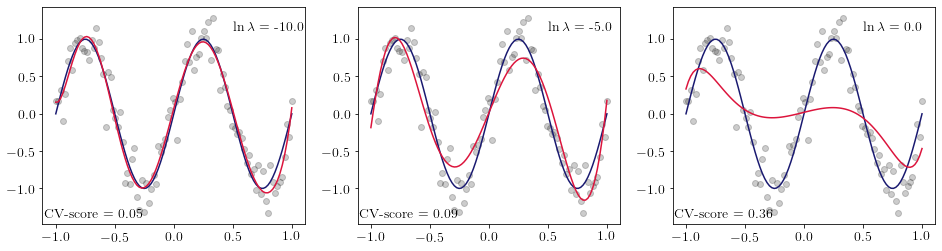

In [24]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

#Here we are going to use k-fold (explicitly LOO) cross validation to estimate the value of the regularisation
#coefficient in a ridge regression. Other applications of k-fold CV might be to compare different modelling
#approaches to the same data set. For example, Lasso vs Ridge vs GPR vs SVM vs K-nearest neighbour etc etc.

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X,y,λ): #ridge regression
    L = np.linalg.cholesky(np.dot(X.T,X) + λ*np.eye(X.shape[1]))
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return w

n = 100 #data set
k_fold = n #equivalent to leave-one-out cross-validation
sn2 = 0.2

x = np.linspace(-1,1,n)
fx = f(x)
y = fx + np.random.normal(0,sn2,n)

indices = np.arange(n)
fold_sizes = np.array(np.full(k_fold,n // k_fold, dtype=np.int))
    
λs = [np.exp(-10),np.exp(-5),1]
CV_scores = []
for λ in λs:
    current = 0
    k_score = []
    for k in range(k_fold):
        #split data set into training and test sets
        start,stop = current, current + fold_sizes[k]
        ID = indices[start:stop]
        mask = np.zeros(n,dtype=np.bool)
        mask[ID] = True
        train_ID = indices[np.logical_not(mask)]
        test_ID = indices[mask]
        x_train = x[train_ID] ; y_train = y[train_ID]
        x_test = x[test_ID] ; y_test = y[test_ID]
        #fit training data
        ϕ_train = np.array([np.ones(len(x_train)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,\
                            x_train**6,x_train**7,x_train**8,x_train**9]).T
        w = fit(ϕ_train,y_train,λ)
        #validate
        ϕ_test = np.array([np.ones(len(x_test)),x_test,x_test**2,x_test**3,x_test**4,x_test**5,x_test**6\
                           ,x_test**7,x_test**8,x_test**9]).T
        Jw = np.dot((y_test - np.dot(ϕ_test,w)).T,(y_test - np.dot(ϕ_test,w)))# + λ*np.dot(w.T,w)/2
        k_score.append(Jw)
        current = stop
    CV_scores.append(np.mean(k_score))

ϕ_train = np.array([np.ones(len(x)),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T
fits = []
for λ in λs:
    w = fit(ϕ_train,y,λ)
    fits.append(np.dot(ϕ_train,w))
fig,ax = plt.subplots(1,3,figsize=(16,4))
for c in range(3):
    ax[c].scatter(x,y,color='k',alpha=0.2,label='observations')
    ax[c].plot(x,fx,color='midnightblue',label='$f(x)$')
    ax[c].plot(x,fits[c],color='crimson',label='fit')
    ax[c].text(0.5,1.1,'$\ln\lambda$ = '+str(np.log(λs[c])))
    ax[c].text(-1.1,-1.4,'CV-score = '+str('%.2f'%CV_scores[c]))
plt.show()

#The plots show that the model with a regularisation coefficient of np.exp(-10) has the lowest CV score and is the
#best value to fit the data.


# Bayesian Linear Regression

This cell below is code based on pages 154-155 of Bishop, 2006, and pages 8-12 of Rasmussen and Williams, 2006.

The Bayesian approach is centered around updating prior beliefs in the presence of new information/data. In the linear regression problem, we place a prior belief over the distribution of the regression weights p(w) ~ N(μ_prior,Σ_prior) before seeing any observations. Upon seeing the observations we determine the likelihood of the observations, given the regression parameters, factored over the training set: p(y|x,w) ~ N(x^Tw,σ^2I). We then use Bayes' Law to derive a posterior distribution for the regression weights, which means we get uncertainty estimates on w for free: p(w|y,x) ~ N(((x^Tx/σ^2 + Σ_prior)^-1x^Ty)/σ^2,(x^Tx/σ^2 + Σ_prior)^-1).
Bayesian linear regression avoids the over-fitting problem encountered in maximum likelihood methods and leads to automatic methods for determining model complexity using the training data alone (i.e do not need to use indepdent hold out data).



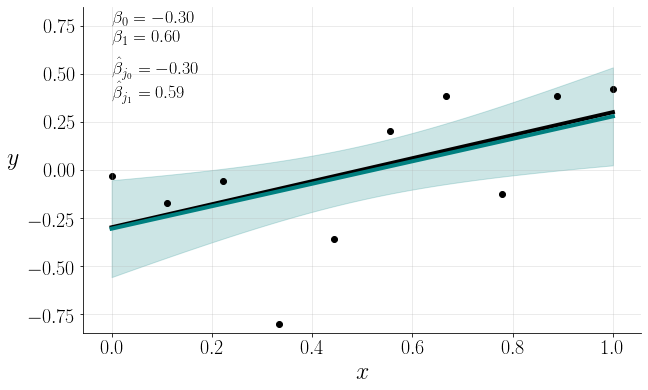

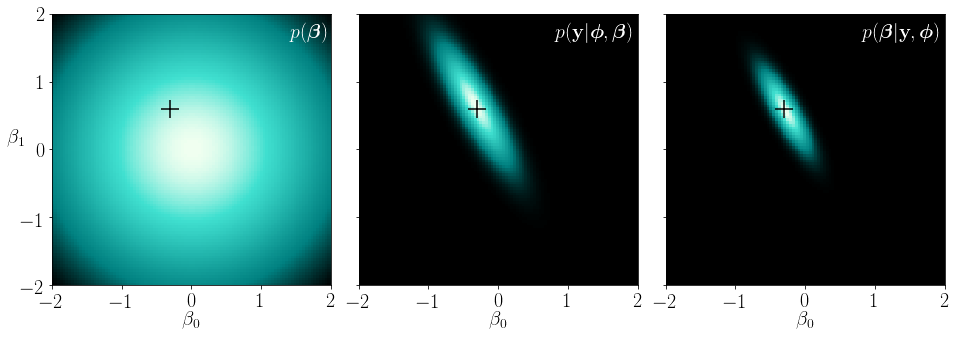

In [39]:
from numpy.linalg import multi_dot as mdot
import matplotlib as mpl
import scipy
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(20)

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 20

norm = mpl.colors.Normalize(0,1)
colors = [[norm(0), "black"],[norm(0.25),"teal"],[norm(0.5), "lightseagreen"],\
          [norm(.75),"turquoise"],[norm(1),"honeydew"]]
tealz = mpl.colors.LinearSegmentedColormap.from_list("", colors)

#CREATE LINEAR TRAINING DATA, THE 'UNKNOWN' PARAMETERS OF WHICH WE WISH TO LEARN
w0_true = -0.3
w1_true = 0.6
n = 10
M = 100
sn2 = 0.3
x = np.linspace(0,1,n)
noise = np.random.normal(0,sn2,n)
w0_samples = np.linspace(-2,2,M)
w1_samples = np.linspace(-2,2,M)
w0,w1 = np.meshgrid(w0_samples,w1_samples)

y = (w0_true + x*w1_true) + noise

#PLOT TRAINING DATA
xs = np.linspace(0,1,100)
fig,ax = plt.subplots(1,figsize=(10,6))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.plot(x,x*w1_true + w0_true, color='k',linewidth=4, label='$f$')
ax.plot(xs,ys2,color='teal',linewidth=4)
ax.fill_between(xs,ys2-np.sqrt(sn2s2),ys2+np.sqrt(sn2s2),color='teal',alpha=.2)
ax.scatter(x,y,color='k')
ax.set_xlabel('$x$',fontsize=24)
ax.set_ylabel('$y$',rotation=0, labelpad=15,fontsize=24)
ax.text(0.,.75,r'$\beta_0 = -0.30$',fontsize=18)
ax.text(0.,.65,r'$\beta_1 = 0.60$',fontsize=18)
ax.text(0.,.475,r'$\hat{\beta}_{j_0} = -0.30$',fontsize=18)
ax.text(0.,.35,r'$\hat{\beta}_{j_1} = 0.59$',fontsize=18)
ax.set_ylim(-0.85,0.85)
ax.grid(True,alpha=.3)
plt.show()

#GET LIKELIHOOD AND POSTERIOR (see e.g eq 2.3 and 2.7 Rasmussen and Williams, 2006)
constant = (1/(2*np.pi*sn2)**(n/2))
likelihood = np.zeros((M,M))
posterior = np.zeros((M,M))
μ_prior = np.zeros(2) #prior mean
Σ_prior = np.eye(2)*2.5 #prior covariance
X = np.asarray([np.ones(n),x]).T
w_mean = μ_prior + (1/sn2)*mdot([np.linalg.inv((1/sn2)*np.dot(X.T,X) + np.diag(1/Σ_prior.diagonal())),X.T,y - np.dot(X,μ_prior)])
for ix in range(M):
    for jx in range(M):
        w = np.asarray([w0[ix,jx],w1[ix,jx]])
        likelihood[ix,jx] = constant * np.exp(-np.dot((y - np.dot(X,w)).T,y - np.dot(X,w))/(2*sn2))
        posterior[ix,jx] = np.exp(-mdot([(w-w_mean).T,(1/sn2)*np.dot(X.T,X) + np.diag(1/Σ_prior.diagonal()),(w-w_mean)]))

#PLOT PRIOR --> LIKELIHOOD --> POSTERIOR
fig,ax = plt.subplots(1,3,sharey=True,figsize=(16,5))
prior = scipy.stats.multivariate_normal([0, 0], [[2.5, 0], [0, 2.5]])
pos = np.empty(w0.shape + (2,))
pos[:, :, 0] = w0 ; pos[:, :, 1] = w1
data = [prior.pdf(pos),likelihood,posterior] ; captions = [r'$p(\boldsymbol{\beta})$',\
                                                           r'$p(\textbf{y}|\boldsymbol{\phi},\boldsymbol{\beta})$',\
                                                           r'$p(\boldsymbol{\beta}|\textbf{y},\boldsymbol{\phi})$']
label = [1.4,.8,.8]
for c in range(3):
    s = ax[c].pcolor(w0,w1,data[c], cmap=tealz, rasterized=True)
    #s = ax[c].contour(w0,w1,data[c])
    if c == 0:
        ax[c].set_ylabel(r'$\beta_1$', rotation=0)
    ax[c].set_xlabel(r'$\beta_0$') 
    ax[c].set_ylim(-2,2,0.5)
    ax[c].scatter(w0_true,w1_true, marker='+',color='k', s=300)
    ax[c].text(label[c],1.65,captions[c],fontsize=20,color='white')
    #if c == 2:
    #divider = make_axes_locatable(ax[c])
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    #plt.colorbar(s, cax=cax, pad=0.07)
        #cbar = fig.colorbar(s, ax=ax[c])#, orientation='horizontal', pad=0.07, fraction=0.027)
        #cbar.solids.set_rasterized(True)
        #cbar.solids.set_edgecolor("face")
    #else:
    #    divider = make_axes_locatable(ax[c])
    #    cax = divider.append_axes('right', size='5%', pad=0.05)
    #    cax.axis('off')
plt.subplots_adjust(wspace=0.1)
plt.show()

#In practice we wouldn't perform BLR like the above. Let's do an example of a practical implementation:
n = 10
ϕ = np.asarray([np.ones(n),x]).T #use same data as previously but augment x with a vector of 1s (for the bias term)
sn2 = 0.2
M = 2 #there are 2 parameters we want to learn, the gradient and the bias term.

#define the prior w ~ N(0,Σ_prior) eq 2.4 Rasmussen and Williams, 2006
μ_prior = np.zeros(M) #zero mean prior 
Σ_prior = np.eye(M)*2.5 #prior covariance matrix
y_ = y - np.dot(ϕ,μ_prior) #compute this here for convenience

#Compute based on equation 2.11 of Rasmussen and Williams, 2006
A = (1/sn2)*np.dot(ϕ.T,ϕ) + np.diag(1/Σ_prior.diagonal()) #inverse of a diagonal matrix = 1/diagonal_elements
L = np.linalg.cholesky(A)
μ_posterior = μ_prior + (1/sn2)*np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ.T,y_)))
#note that the above expression is essentially written as (sn2^-1ϕ.Tϕ + Σ_prior^-1)^-1ϕ.Ty.
#The posterior of the regression weights is given by: p(w|y,ϕ) \propto exp(-1/2*sn2 * (y-ϕw)^2) * exp(-w^TΣ_priorw/2)
#If we maximise the logarithm of the posterior distribution with respect to w, then this is equivalent to the 
#minimisation of the sum of squares error function with an additional quadratic penalty term, i.e Ridge Regression.
#In ridge regression the quadratic penalty is λw^Tw/2. In BLR it is w^TΣ_priorw/2sn2
Σ_posterior = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(M))) #covariance matrix of the posterior distribution

ϕs = np.asarray([np.ones(100),np.linspace(0,1,100)]).T
K = mdot([ϕ,Σ_prior,ϕ.T]) + sn2*np.eye(n) #this is our linear kernel function (n x n Gram matrix)
k = mdot([ϕs,Σ_prior,ϕ.T]) #covariance between test inputs and training inputs
ks = mdot([ϕs,Σ_prior,ϕs.T]) #covariance between test inputs
L = np.linalg.cholesky(K) 
α1 = np.linalg.solve(L.T,np.linalg.solve(L,y_))
#α2 = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ,Σ_prior)))
#μ_posterior2 = μ_prior + mdot([Σ_prior,ϕ.T,α1]) #we don't need to explicitly define the posterior to make predictions
#Σ_posterior2 = Σ_prior - mdot([Σ_prior,ϕ.T,α2])

v = np.linalg.solve(L.T,np.linalg.solve(L,k.T))
ys2 = np.dot(k,α1) #predictive mean
sn2s2 = (ks - np.dot(k,v)).diagonal() #predictive variance

# The Bridge from Parametric Models to Non-Parametric Kernel Functions

The cell below is code based on pages 159,292-294 of Bishop and also page 12 of R&W.

Many linear parametric models can be re-cast into an equivalent 'dual representation' in which the predictions are also based on linear combinations of a kernel function evaluated at the training data points. For models which are based on a fixed nonlinear feature space mapping ϕ(x), the kernel function is given by k(x,x') = ϕ(x)^Tϕ(x'). Although we could also consider the simplest example of a kernel function by the identity mapping so that ϕ(x) = x, such that k(x,x') = x^Tx' (i.e a linear kernel). The fact that the kernel is formulated as an inner product in a feature space allows us to use the kernel trick (or kernel substitution). The idea is that if we have an algorithm formulated in such a way that the input vector x enters only in the form of scalar products, then we can replace that scalar product with some other choice of kernel.

In [ ]:
import numpy as np
from numpy.linalg import multi_dot as mdot
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt

np.random.seed(2)

def f(x):
    np.random.seed(2)
    return np.random.multivariate_normal(np.zeros(n),np.exp(-squareform(pdist(np.atleast_2d(x).T/0.3,'sqeuclidean'))))

#Generate some synthetic data
n = 200 #number of observations
sigma2 = 0.5 #noise variance
x = np.linspace(-1,1,n) #inputs
phi = np.array([np.ones(n),x,x**2,x**3,x**4,x**5,x**6]) #polynomial basis function projection
N = phi.shape[0] #number of parameters
fx = f(x) #true function values drawn from a Gaussian process
y = fx + np.random.normal(0,sigma2,n) #add random Gaussian noise to produce outputs

Vi = np.eye(n)*(1/sigma2) #inverse covariance of the likelihood distribution
Sigmai = np.eye(N)*(1/100) #inverse prior covariance over the regression parameters

#Generate mean of predictive distribution
phi_mu_tilde = mdot([phi.T,inv(mdot([phi,Vi,phi.T]) + Sigmai),phi,Vi,y]) #posterior predictive distribution at phi

kx = mdot([phi.T,inv(mdot([phi,Vi,phi.T]) + Sigmai),phi,Vi]) #equivalent kernel

#plot kernel and extract profiles 
plt.imshow(kx,cmap='jet',vmin=0,vmax=0.05)
plt.hlines(50,200,0,color='k',alpha=0.25)
plt.hlines(100,200,0,color='k',alpha=0.5)
plt.hlines(150,200,0,color='k',alpha=1)
plt.xlim(n,0)
plt.ylim(n,0)
plt.show()

plt.plot(x,kx[:,50],color='k',lw=2,alpha=1)
plt.plot(x,kx[:,100],color='k',lw=2,alpha=0.5)
plt.plot(x,kx[:,150],color='k',lw=2,alpha=0.25)
plt.show()

#show that linear combination of outputs is equivalent to mean of predictive distribution
linear_comb = [kx[:,i] * y[i] for i in range(n)] #linear combination of the outputs
print(np.isclose(phi_mu_tilde,np.sum(linear_comb,0),atol=1e-15)) #check equivalence

In [10]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x):
    return np.sin(2*np.pi*x)

#Let's consider a linear regression model whose parameters are determined by minimizing the regularised sum of
#squares error function J(w):

#generate synthetic data from function sin(2pix)
n = 8
sn2 = 0.2
x = np.linspace(-1,1,n)
x_smooth = np.linspace(-1,1,200) 
y = f(x) + np.random.normal(0,sn2,n)

λ = np.exp(-12)
ϕ = np.array([np.ones(n),x,x**2,x**3,x**4,x**5]).T #polynomial basis function
M = ϕ.shape[1]

def J(w):
    Jw = y.T.dot(y)/2 - mdot([w.T,ϕ.T,y]) + mdot([w.T,ϕ.T,ϕ,w])/2 + λ*np.dot(w.T,w)/2 #expanded form of (y - x^Tw)^2
    dJdw = -ϕ.T.dot(y) + mdot([ϕ.T,ϕ,w]) + λ*w #gradient with respect to w
    return Jw,dJdw

#w = minimize.run(J,X=np.zeros(M),length=200)

#if we set the gradient of J(w) above to zero then we see that the solution ϕ(x).Tϕ(x)w + λw == ϕ(x).Ty takes the
#form of a linear combination of vectors ϕ(x_n), with coefficients that are functions of w of the form 
#w = -ϕ.T(y - ϕw)/λ. Now we can reformulate J(w) in terms of the parameter vector a = -(y - ϕw)/λ, such that
#w = ϕ.Ta. This gives rise to a dual representation where we can substitute w = ϕ.Ta into J(w) to give:

def J(a):
    Ja = mdot([a.T,ϕ,ϕ.T,ϕ,ϕ.T,a])/2 - mdot([a.T,ϕ,ϕ.T,y]) + np.dot(y.T,y)/2 + λ*mdot([a.T,ϕ,ϕ.T,a])/2
    dJda = mdot([ϕ,ϕ.T,ϕ,ϕ.T,a]) - mdot([ϕ,ϕ.T,y]) + λ*mdot([ϕ,ϕ.T,a]) #gradient with respect to a
    return Ja,dJda

#a = minimize.run(J,X=np.zeros(n),length=200)

#Here we can now define the covariance matrix (kernel function):
K = np.dot(ϕ,ϕ.T)
#This is a real symmetric matrix of inner products which has elements K_nm = ϕ(x_n)^Tϕ(x_m) = k(x_n,x_m), and is
#approximately proportional to the Gram matrix. The vectors ϕ(x) and ϕ(x') are said to be linearly independent
#if the determinant of the Gram matrix (K) is non-zero. Note that the Gram matrix is defined as a Hermitian (complex)
#matrix of inner products such that the element in the i'th row and j'th column is equal to the complex conjugate of
#the element in the j'th row and the i'th column. Now we can re-write J(a) as:

def J(a):
    Ja = mdot([a.T,K,K,a])/2 - mdot([a.T,K,y]) + np.dot(y.T,y)/2 + λ*mdot([a.T,K,a])/2
    dJda = mdot([K,K,a]) - np.dot(K,y) + λ*np.dot(K,a) #gradient with respect to a
    return Ja,dJda

#a = minimize.run(J,X=np.zeros(n),length=200)

#then by setting the gradient of J(a) with respect to a to zero we obtain the solution in closed form:
#Ky = KKa + λKa
#y = Ka + λa
#y = a(K + λI)
#(K + λI)^-1y = a(K + λI)(K + λI)^-1
#(K + λI)^-1y = a
L = np.linalg.cholesky(K + λ*np.eye(n))
a = np.linalg.solve(L.T,np.linalg.solve(L,y))

#We then obtain the following prediction for a new input xs
xs = 0.2
ϕs = np.array([1,xs,xs**2,xs**3,xs**4,xs**5]).T
k = np.dot(ϕs,ϕ.T)
ys1 = np.dot(k.T,a)

#to see this is equivalent with the standard parametric version of regresion:
L = np.linalg.cholesky(np.dot(ϕ.T,ϕ) + λ*np.eye(M)) #invert parametric matrix of size M x M
w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ.T,y)))
ys2 = np.dot(ϕs,w)
#print('%.3f'%ys1,'%.3f'%ys2)

#In the dual formulation we determine the parameter vector 'a' by inverting an n x n matrix, whereas in the original
#parameter space formulation we had to invert an M x M matrix in order to determine w. The advantage of the dual 
#formulation is that it is expressed entirely in terms of the kernel function k(x,x'). We can therefore work directly
#in terms of kernels and avoid the explicit introduction of the feature vector ϕ(x), which allows us implicitly to
#use feature spaces of high, even infinite, dimensionality.


#Let's now revisit Bayesian Linear Regression and show how we can use dual representation to define the posterior
#distribution of the regression weights in terms of a kernel function, where we can see how BLR fits naturally into
#the broader scope of Gaussian Process Regression (GPR is discussed further in the next cell):

#original formulation (eq 2.11 of R&W):
μ_prior = np.zeros(M) #zero mean prior 
Σ_prior = np.eye(M)*0.5 #prior covariance matrix
y_ = y - np.dot(ϕ,μ_prior) #compute this here for convenience

A = (1/sn2)*np.dot(ϕ.T,ϕ) + np.diag(1/Σ_prior.diagonal()) #A is a M x M parameter matrix
L = np.linalg.cholesky(A)
μ_posterior1 = μ_prior + (1/sn2)*np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ.T,y_)))
Σ_posterior1 = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(M)))

ys1 = np.dot(ϕs,μ_posterior1) #predictive mean
sn2s1 = mdot([ϕs,Σ_posterior1,ϕs.T]) #predictive variance

#dual representation (eq 2.12 of R&W):
K = mdot([ϕ,Σ_prior,ϕ.T]) + sn2*np.eye(n) #this is our linear kernel function (n x n Gram matrix)
k = mdot([ϕs,Σ_prior,ϕ.T]) #covariance between test inputs and training inputs
ks = mdot([ϕs,Σ_prior,ϕs.T]) #covariance between test inputs
L = np.linalg.cholesky(K) 
α1 = np.linalg.solve(L.T,np.linalg.solve(L,y_))
#α2 = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ,Σ_prior)))
#μ_posterior2 = μ_prior + mdot([Σ_prior,ϕ.T,α1]) #we don't need to explicitly define the posterior to make predictions
#Σ_posterior2 = Σ_prior - mdot([Σ_prior,ϕ.T,α2])

v = np.linalg.solve(L.T,np.linalg.solve(L,k))
ys2 = np.dot(k,α1) #predictive mean
sn2s2 = ks - np.dot(k,v) #predictive variance

print('predictive mean of parametric formulation:','%.4f'%ys1)
print('predictive mean of dual representation formulation:','%.4f'%ys2)
print('predictive variance of parametric formulation:','%.4f'%sn2s1)
print('predictive variance of dual representation formulation:','%.4f'%sn2s2)

predictive mean of parametric formulation: -0.1084
predictive mean of dual representation formulation: -0.1084
predictive variance of parametric formulation: 0.0470
predictive variance of dual representation formulation: 0.0470


# Gaussian Process Regression (Kriging)

The cell below is code based on pages 13-16 of Rasmussen and Williams, 2006.

We have seen above how, through dual representation, parametric regression models can be equivalently represented in terms of kernel functions evaluted over the inputs. We also briefly saw how BLR can be expressed in such light, defining it as a form of Gaussian Process Regression, which we discuss here...

Gaussian process regression is a Bayesian inference technique which can be thought of as the 'function space' approach to Bayesian linear regression. In this sense, GPR does away with the parametric model setup from BLR (i.e the regression weights w) and instead moves towards fully non-parametric models and allows for non-linear fits - N.B that BLR does also allow for non-linear fits if we map the inputs to high dimensional feature spaces using basis functions. Recalling the model y = f(x) + noise; in BLR we placed a prior over the regression weights p(w) as f(x) = x^Tw. In the non-parametric GPR approach the equivalent to p(w) is a prior over the function f(x) directly. Then, a prior with zero-mean can be fully specified by its covariance between the function values for two arbitrary inputs: f(x)f(x') = k(x,x') = K(X,X). From this prior one obtains a posterior over functions in the form: p(fs|X,y,Xs) ~ N(K(Xs,X){K(X,X) + σ^2I}^-1y,K(Xs,Xs)-K(Xs,X){K(X,X) + σ^2I}^-1K(X,Xs)). Where (X,y) are training inputs and Xs are test inputs.

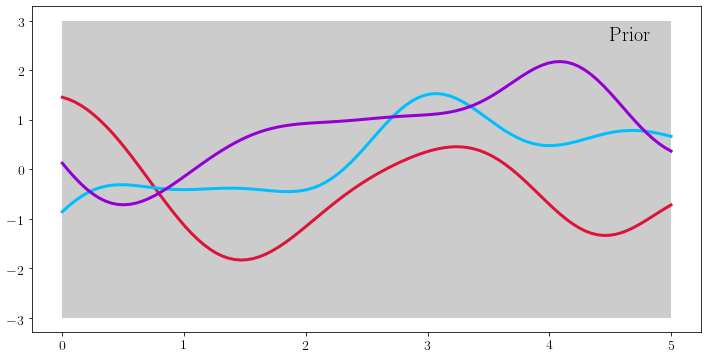

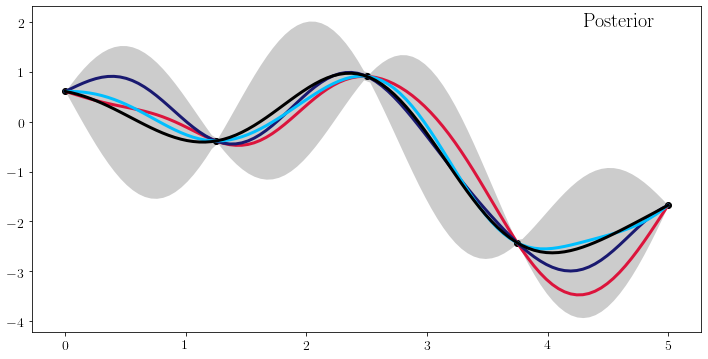

In [13]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline
import random

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #prior
    k = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def fs(x,xs): #posterior
    kx = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)) + np.eye(n)*sn2
    kxs = sf2 * np.exp(-.5*cdist(xs,x,'sqeuclidean')/ell)
    kss = sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell))
    L = np.linalg.cholesky(kx)
    α1 = np.linalg.solve(L.T,np.linalg.solve(L,y))
    α2 = np.linalg.solve(L.T,np.linalg.solve(L,kxs.T))
    k = kss - np.dot(kxs,α2)
    m = np.dot(kxs,α1)
    return np.random.multivariate_normal(m,k)

n = 5 #training points
ns = 100 #test points
sf2 = 1 #signal variance (hyperparameter)
ell = 0.5 #length scale (hyperparameter)
sn2 = 0.0 #noise variance (we are going to assume noise free for now)

#x = np.asarray([1,1.5,4]).reshape(n,1) 
x = np.linspace(0,5,n).reshape(n,1) #training inputs
xs = np.linspace(0,5,ns).reshape(ns,1) #test inputs

#draw samples from the prior
p1 = f(xs) 
p2 = f(xs)
p3 = f(xs)

#generate actual mean and variance of the prior
fmean = np.zeros(ns)
fvar = sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell)) + np.eye(ns)*sn2

fig,ax = plt.subplots(1,figsize=(12,6))
plt.plot(xs,p1,color='crimson',lw=3.)
plt.plot(xs,p2,color='deepskyblue',lw=3.)
plt.plot(xs,p3,color='darkviolet',lw=3.)
plt.fill_between(xs[:,0],fmean + 3*np.sqrt(fvar.diagonal()), fmean - 3*np.sqrt(fvar.diagonal()),\
                color='k',alpha=0.2,linewidths=0.0)
plt.text(4.5,2.6,'Prior',fontsize=20)
plt.show()

y = f(x) + np.random.normal(0,sn2,n)

#draw samples from the posterior
fs1 = fs(x,xs)
fs2 = fs(x,xs)
fs3 = fs(x,xs)

#generate actual mean and variance of posterior
kx = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)) + np.eye(n)*sn2
kxs = sf2 * np.exp(-.5*cdist(xs,x,'sqeuclidean')/ell)
kss = sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell))

L = np.linalg.cholesky(kx)
α1 = np.linalg.solve(L.T,np.linalg.solve(L,y))
α2 = np.linalg.solve(L.T,np.linalg.solve(L,kxs.T))
fvar = kss - np.dot(kxs,α2)
fmean = np.dot(kxs,α1)

fig,ax = plt.subplots(1,figsize=(12,6))
plt.plot(xs,fs1,color='crimson',lw=3.)
plt.plot(xs,fs2,color='midnightblue',lw=3.)
plt.plot(xs,fs3,color='deepskyblue',lw=3.)
plt.plot(xs,fmean,color='k',lw=3.)
plt.fill_between(xs[:,0],fmean + 3*np.sqrt(fvar.diagonal()), fmean - 3*np.sqrt(fvar.diagonal()),\
                color='k',alpha=0.2,linewidths=0.0)
plt.scatter(x,y,color='k')
plt.text(4.3,1.9,'Posterior',fontsize=20)
plt.show()

#In the first image the grey area represents the prior space of functions. This means we expect our data to be
#generated from any function that falls within this range. Note that a prior over functions mean theoretically we
#place a prior over an infinite number of different functions. Here we show just 3 of them as an example. In the
#second image we see our training observations, where we can then 'condition' the prior distribution on the
#observations to create the posterior over functions. Here we plot 3 functions (coloured) drawn from this posterior,
#and then the actual mean and variance (3 standard devs) of the posterior in black/grey.



# 2-D Gaussian Process Regression (Spatial Interpolation)

Looking at the image of the posterior function above, we can clearly see how Gaussian Process Regression behaves as an interpolation engine, given by the predictive mean (and variance) between observations. If we think of these observations as spatial locations on a grid then it is easy to perfom 2-D interpolation of any given spatial field using identical equations as previously. Here we show a synthetic example.

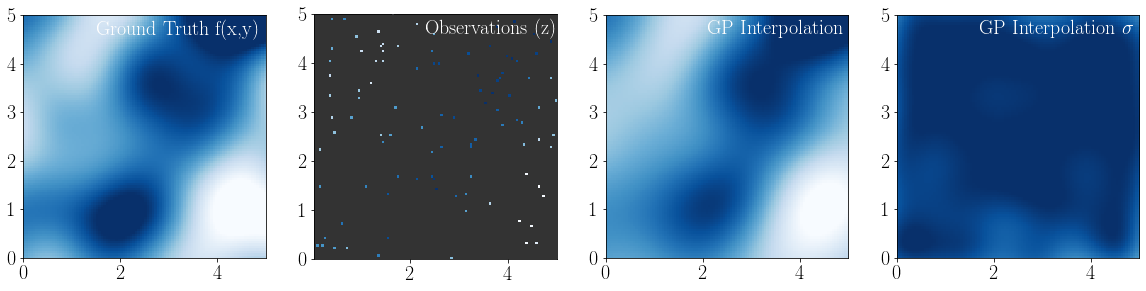

In [35]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline
import random
from funcs import draw_meridians
from mpl_toolkits.basemap import Basemap

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 20

np.random.seed(20)
random.seed(20)

def f(x,y): #draw data from a Gaussian Process
    k = sf2 * np.exp(-.5*squareform(pdist(np.array([x.ravel(),y.ravel()]).T/ell,'sqeuclidean')))
    m = np.zeros(grid_cells)
    return np.random.multivariate_normal(m,k)

sf2 = 1 #signal variance
ell = [1,1] #length-scale (x and y)
sn2 = 0.2 #noise variance

grid_cells = 10000
dX = dY = int(np.sqrt(grid_cells))
x,y = np.meshgrid(np.linspace(0, 5, dX),np.linspace(0, 5, dY))
fxy = f(x,y)

truth = np.asarray([x.ravel(),y.ravel(),fxy]).T #ground truth

n = 100 #training points
data = np.zeros((grid_cells,3)) ; data[data==0] = np.nan
training_cells = np.array(random.sample(range(grid_cells-1),n))
x_train = truth[:,0][training_cells]
y_train = truth[:,1][training_cells]
z_train = truth[:,2][training_cells] + np.random.normal(0,sn2,n)
data[:,0][training_cells] = x_train
data[:,1][training_cells] = y_train
data[:,2][training_cells] = z_train 

ns = grid_cells
x_test = x.ravel()
y_test = y.ravel()
X = np.array([x_train,y_train]).T
Xs = np.array([x_test,y_test]).T

KX = sf2 * np.exp(-.5*squareform(pdist(X/ell,'sqeuclidean'))) + np.eye(n)*sn2
KXs = sf2 * np.exp(-.5*squareform(pdist(Xs/ell,'sqeuclidean')))
KXXs = sf2 * np.exp(-.5*cdist(Xs/ell,X/ell,'sqeuclidean'))

L = np.linalg.cholesky(KX)
α1 = np.linalg.solve(L.T,np.linalg.solve(L,z_train))
α2 = np.linalg.solve(L.T,np.linalg.solve(L,KXXs.T))
fmean = np.dot(KXXs,α1)
fvar = KXs - np.dot(KXXs,α2) + sn2

fig,ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(truth[:,2].reshape(dX,dY),\
           extent=(np.min(truth[:,0]),np.max(truth[:,0]),np.min(truth[:,1]),np.max(truth[:,1])),vmin=-1.5,vmax=1.5,cmap='Blues_r')
ax[0].text(1.5,4.6,'Ground Truth f(x,y)',color='white')
ax[1].imshow(data[:,2].reshape(dX,dY),\
           extent=(np.nanmin(data[:,0]),np.nanmax(data[:,0]),np.nanmin(data[:,1]),np.nanmax(data[:,1])),vmin=-1.5,vmax=1.5,cmap='Blues_r')
ax[1].set_facecolor((0.2,0.2,0.2))
ax[1].text(2.3,4.6,'Observations (z)',color='white')
ax[2].imshow(fmean.reshape(dX,dY),\
          extent=(np.min(truth[:,0]),np.max(truth[:,0]),np.min(truth[:,1]),np.max(truth[:,1])),vmin=-1.5,vmax=1.5,cmap='Blues_r')
ax[2].text(2.1,4.6,'GP Interpolation',color='white')
ax[3].imshow(np.sqrt(fvar.diagonal()).reshape(dX,dY),\
          extent=(np.min(truth[:,0]),np.max(truth[:,0]),np.min(truth[:,1]),np.max(truth[:,1])),vmin=0.5,vmax=1,cmap='Blues_r')
ax[3].text(1.7,4.6,'GP Interpolation $\sigma$',color='white')
plt.show()


# Bayesian Model Selection (Hyperparameter Optimisation)

The code below is based on pages 161-165 of Bishop and 112-116 of R&W.

We saw earlier the problem of overfitting, as well as the use of cross-validation as a technique for setting the values of regularisation parameters (or equivalently for choosing between alternative models). Here we consider the problem of model selection from a Bayesian perspective. We will see how in this approach we can avoid overfitting by marginalising (summing or integrating) over the model parameters instead of making point estimates of their values. Models can then be compared directly on the training data, without the need for a validation set. This avoids the multiple training runs for each model associated with CV, and allows multiple complexity parameters to be determined simultaneously. In the examples above we have seen a few times a number of free parameters which have been given, such as the noise variance term sn2, the characteristic length scale ell, or the function variance sf2. Similar to the regularisation coefficient, these terms govern the complexity of our Bayesian model. In the Bayesian approach we can optimise these hyperparameters by maximising the log marginal likelihood lnp(y|x). The marginal likelihood p(y|x) normalises the posterior distribution so that probabilities sum to one, and maximising its logarithm is a way to make the probability of the observations (x,y) under the model prior as large as possible.



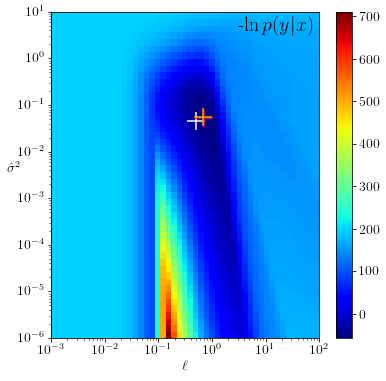

In [35]:
import numpy as np
from numpy.linalg import multi_dot as mdot
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(1)

def f(x): #prior
    k = sf2_true * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell_true))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def MLII(hyperparameters): #empirical Bayesian approach known as type-II maximum likelihood
    ell = np.exp(hyperparameters[0]) ; sn2_hat = np.exp(2*hyperparameters[1])
    try:
        L = np.linalg.cholesky(np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) + np.eye(n)*sn2_hat)
        α = ((np.linalg.solve(L.T,np.linalg.solve(L,y))).reshape(n,1))
        sf2 = np.dot(y.T,α)/n ; sn2 = sf2*sn2_hat
        L = np.linalg.cholesky(sf2 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) + np.eye(n)*sn2)
        α = (np.linalg.solve(L.T,np.linalg.solve(L,y))).reshape(n,1)
        nlZ = np.dot(y.T,α)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2 #Algorithm 2.1 R&W
        
        Q = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(n))) - np.dot(α,α.T)
        dK1 = sf2 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) * squareform(pdist(x/ell,'sqeuclidean'))
        dnlZ = [(Q*dK1).sum()/2,sn2_hat*np.trace(Q)] 
        
    except (np.linalg.LinAlgError) as e:
        nlZ = np.inf ; dnlZ = np.array([np.inf,np.inf])
    return nlZ,np.array(dnlZ)


n = 100 #training points
sf2_true = 2.2 #signal variance (hyperparameter)
ell_true = 0.5 #length scale (hyperparameter)
sn2_true = 0.1 #noise variance (hyperparameter)
sn2_hat_true = sn2_true/sf2_true
#the above hyperparameters are what we would like to recover by maximising the log marginal likelihood, or
#equivalently, minimising the negative log marginal likelihood

x = np.linspace(0,5,n).reshape(n,1) #training inputs
y = f(x) + np.random.normal(0,sn2_true,n)
  
t = 50
ell = np.logspace(-3,2,t)
sn2_hat = np.logspace(-6,1,t)
ell,sn2_hat = np.meshgrid(ell,sn2_hat)
nlML = np.zeros((t,t))
for ix in range(t):
    for jx in range(t):
        nlML[ix,jx] = MLII([np.log(ell[ix,jx]),np.log(sn2_hat[ix,jx])])[0]

hyp = minimize.run(MLII,X=[np.log(1),np.log(1)],length=40)

fig,ax = plt.subplots(1,figsize=(6,6))
s = plt.pcolor(ell,sn2_hat,nlML,cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$\hat\sigma^2$',rotation=0)
plt.text(3,4,'-$\ln p(y|x)$',fontsize=20)
plt.scatter(ell_true,sn2_hat_true, marker='+',color='white', s=300) #true hyperparameters
plt.scatter(ell[np.where(nlML==np.nanmin(nlML))],sn2_hat[np.where(nlML==np.nanmin(nlML))],\
            marker='+',color='crimson', s=300) #minimum of negative log marginal likelihood (grid search)
plt.scatter(np.exp(hyp[0]),np.exp(hyp[1]),marker='+',color='orange', s=300) #minimum found by numerical optimisation
plt.colorbar(s)
plt.show()


# Multi-Task Gaussian Process Regression (Cokriging)

So far we have only considered regression cases where training inputs and outputs correspond to single vectors. Indeed it is easy enough to incorporate multiple inputs into regression such that the inputs become an n x N design matrix, with N being the number of predictors. However sometimes we may want to make predictions of multiple outputs, for example we may want to make spatial predictions of a given climate variable at the nth + 1 point in time. In the typical GPR approach we might iterate through each of the grid cell points which make up our spatial field and then treat each grid cell as an individual task for which we want to learn the function f(x) and subsequently make predictions. This would be called the "no transfer" approach. However in this case we lose the ability to incorporate any information about the similarity between grid cells (tasks). For example, we would expect a climate field to be somewhat correlated over a given length-scale. With multi-task GPR we form predictions by learning about all grid cells at the same time and subsequently all functions fτ(x) where τ = {1,2,...,T} and T is the total number of tasks. We create a TxT inter-task covariance matrix Kf, which we combine with the typical nxn GP prior K(X,X) using the Kronecker product to achieve the nTxnT matrix K = Kf ⊗ K(X,X) + D ⊗ I, where D is a TxT diagonal matrix containing the noise variance of the τth task σ^2_τ. From there we can solve the typical GPR predictive equations as normal. 2 coded options for inference and prediction are shown below. We shall see how a naively coded multi-task GPR (based on Kronecker products) becomes extremley inefficient for large numbers of tasks. Therefore an alternative approach is to use the methods outlined in works such as Stegle et al (2011) and Rakitsch et al (2013), which involves diagonalisation of matrices to avoid any Kronecker product of matrices. 

time to generate predictions using naive approach: 0.0015850067138671875


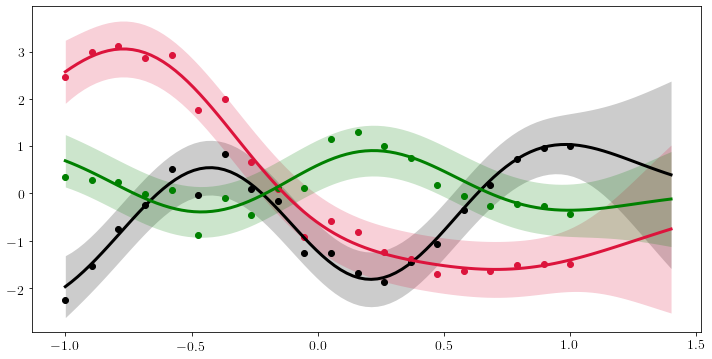

time to generate predictions using efficient approach: 0.003662109375


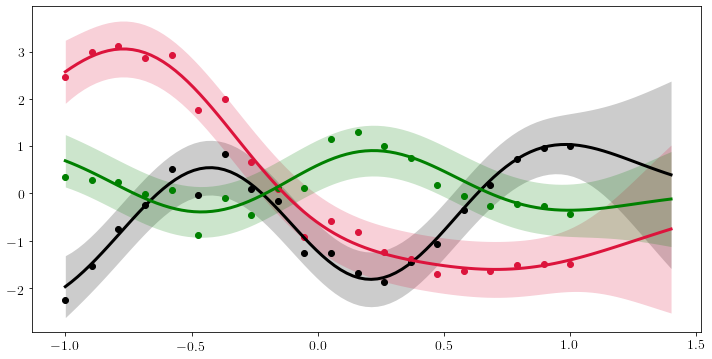

In [16]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import minimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline
import time

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def lowtri2vec(L,τ,irank):
    Lvec = np.zeros(int(irank*(2*τ - irank +1)/2))
    start = 0
    for i in range(τ):
        end = start+len(L[i,:min(i+1,irank)])
        Lvec[start:end] = L[i,:min(i+1,irank)]
        start = end
    return list(Lvec)

def vec2lowtri(Lvec,τ,irank):
    Lvec = np.array(Lvec)
    L = np.zeros((τ,τ))
    low = 0
    for i in range(τ):
        up = min(irank-1,i)
        L[i,:up+1] = Lvec[low:low+up+1]
        low = low + up + 1
    return L

def pos2ind_tri(pos,τ,irank):
    i = 0
    S = [-1]
    j = 0
    while all(s < pos for s in S):
        S.append(S[i] + min(i+1,irank))
        i += 1
    if i > 0:
        j = pos - S[i-1]
    return i-1,j-1

def MLII(hypers):
    ell_x = np.exp(hypers[:N]) ; sf2_x = np.exp(2*hypers[N]) ; sn2 = np.exp(2*hypers[N+1]) ; Ltheta = hypers[N+2:]

    Lf = vec2lowtri(Ltheta,T,rank)
    Kf = np.dot(Lf,Lf.T)
    Kx = sf2_x * np.exp(-.5*squareform(pdist(x/ell_x,'sqeuclidean')))

    Λf, Uf = np.linalg.eigh(Kf)
    Λx, Ux = np.linalg.eigh(Kx)
    Λff,Λxx = np.meshgrid(Λf,Λx)
    Λi = np.diag(1/(np.kron(Λf,Λx) + np.kron(sn2*np.ones(T),np.ones(n))))
    V = mdot([Ux.T,y,Uf]).ravel(order='F')
    Y_tilde = np.dot(Λi,V)
            
    nlZ = mdot([V.T,Λi,V])/2 + np.sum(np.log(Λff*Λxx + sn2))/2 + n*T*np.log(2*np.pi)/2.
    
    dKnlZ = []
    for z in range(len(hypers)):
        if z == 0: #gradient with respect to ell
            dK = sf2 * np.exp(-.5*squareform(pdist(x/ell_x,'sqeuclidean'))) * squareform(pdist(x/ell_x,'sqeuclidean'))
            dK = .5*np.dot(Λi.diagonal().T,np.kron(np.diag(Λf),mdot([Ux.T,dK,Kx,Ux])).diagonal())\
                - .5*np.dot(Y_tilde.T,mdot([Ux.T,dK,Kx,Ux,Y_tilde.reshape(n,T,order='F'),np.diag(Λf)]).ravel(order='F'))
        elif z == 1: #gradient with respect to sf2
            dK = 2 * sf2 * np.exp(-.5*squareform(pdist(x/ell_x,'sqeuclidean')))
            dK = .5*np.dot(Λi.diagonal().T,np.kron(np.diag(Λf),mdot([Ux.T,dK,Kx,Ux])).diagonal())\
                - .5*np.dot(Y_tilde.T,mdot([Ux.T,dK,Kx,Ux,Y_tilde.reshape(n,T,order='F'),np.diag(Λf)]).ravel(order='F'))
        elif z == 2: #gradient with respsect to sn2
            dK = np.sum(-1/(Λff*Λxx + sn2)) + mdot([V.T,Λi,sn2*np.eye(T*n),Λi,V])
        else:
            o,p = pos2ind_tri(z-3,T,rank)
            J = np.zeros((T,T)) ; J[o,p] = 1
            dK = np.dot(J,Lf.T) + np.dot(Lf,J.T)
            dK = .5*np.dot(Λi.diagonal().T,np.kron(np.diag(Λx),mdot([Uf.T,dK,Kf,Uf])).diagonal())\
               - .5*np.dot(Y_tilde.T,mdot([Uf.T,dK,Kf,Uf,Y_tilde.reshape(n,T,order='F').T,np.diag(Λx)]).ravel(order='F'))
        dKnlZ.append(dK)

    return nlZ#, np.array(dKnlZ)

n = 20 #training points
ns = 100 #test points
T = 3 #number of tasks
rank = T #full rank
sf2 = 1 #signal variance (hyperparameter)
ell = 0.1 #length scale (hyperparameter)
sn2 = [0.3]*T #noise variance

x = np.linspace(-1,1,n).reshape(n,1) #training inputs
xs = np.linspace(-1,1.4,ns).reshape(ns,1) #test inputs
N = 1

y = (np.random.multivariate_normal(np.zeros(n),\
                                  sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)), T) + \
                                  np.random.normal(0,sn2[0],n)).T

Kf0 = np.eye(T) #free-form inter-task covariance matrix (Bonilla, 2008)
Ltheta0 = lowtri2vec(Kf0,T,rank) #all elements of lower triangle matrix are treated as hyperparameters
hypers = [np.log(1),np.log(1),np.log(0.1)]+Ltheta0
hypers = scipy.optimize.minimize(MLII,x0=hypers,jac=False).x
#hypers = minimize.run(MLII,X=hypers,length=200)
ell_x = np.exp(hypers[:N]) ; sf2_x = np.exp(2*hypers[N]) ; sn2 = [np.exp(2*hypers[N+1])]*T
Ltheta = hypers[N+2:]

L = vec2lowtri(Ltheta,T,rank)
Kf = np.dot(L,L.T)
Kx = sf2 * np.exp(-.5*squareform(pdist(x/ell_x,'sqeuclidean')))
Kxs = sf2 * np.exp(-.5*squareform(pdist(xs/ell_x,'sqeuclidean')))
Kxsx = sf2 * np.exp(-.5*cdist(xs/ell_x,x/ell_x,'sqeuclidean'))

D = np.diag(sn2)
I = np.eye(n)

#NAIVE APPROACH, BASED ON KRONECKER PRODUCTS:
t = time.time()
K = np.kron(Kf,Kx) + np.kron(D,I)
L = np.linalg.cholesky(K)
alpha1 = np.linalg.solve(L.T,np.linalg.solve(L,y.ravel(order='F')))
alpha2 = np.linalg.solve(L.T,np.linalg.solve(L,np.kron(Kf,Kxsx).T))

fm = np.dot(np.kron(Kf,Kxsx),alpha1).reshape(ns,T,order='F')
fs2 = ((np.kron(Kf,Kxs) - np.dot(np.kron(Kf,Kxsx),alpha2)).diagonal() + sn2[0]).reshape(ns,T,order='F')
print('time to generate predictions using naive approach:',time.time()-t)

fig,ax = plt.subplots(1,figsize=(12,6))

plt.plot(xs,fm[:,0],color='k',lw=3.)
plt.fill_between(xs[:,0],fm[:,0] + 2*np.sqrt(fs2[:,0]), fm[:,0] - 2*np.sqrt(fs2[:,0]),\
                color='k',alpha=0.2,linewidths=0.0)
plt.plot(xs,fm[:,1],color='crimson',lw=3.)
plt.fill_between(xs[:,0],fm[:,1] + 2*np.sqrt(fs2[:,1]), fm[:,1] - 2*np.sqrt(fs2[:,1]),\
                color='crimson',alpha=0.2,linewidths=0.0)
plt.plot(xs,fm[:,2],color='green',lw=3.)
plt.fill_between(xs[:,0],fm[:,2] + 2*np.sqrt(fs2[:,2]), fm[:,2] - 2*np.sqrt(fs2[:,2]),\
                color='green',alpha=0.2,linewidths=0.0)

plt.scatter(x,y[:,0],color='k')
plt.scatter(x,y[:,1],color='crimson')
plt.scatter(x,y[:,2],color='green')
plt.show()

#EFFICIENT APPROACH, Stegle et al (2011) & Rakitsch et al (2013)
t = time.time()
ΛD, UD = np.linalg.eigh(D)
ΛI, UI = np.linalg.eigh(I)

Kf_ = mdot([np.diag(ΛD**-.5),UD.T,Kf,UD,np.diag(ΛD**-.5)])
Kx_ = mdot([np.diag(ΛI**-.5),UI.T,Kx,UI,np.diag(ΛI**-.5)])
Λf_, Uf_ = np.linalg.eigh(Kf_)
Λx_, Ux_ = np.linalg.eigh(Kx_)
Λi = np.diag(1/(np.kron(Λf_,Λx_) + np.ones(n*T)))

V = mdot([Ux_.T,np.diag(ΛI**-.5),UI.T,y,UD,np.diag(ΛD**-.5),Uf_]).ravel(order='F')
y_ = np.dot(Λi,V).reshape(n,T,order='F')

fm = mdot([Kxsx,UI,np.diag(ΛI**-.5),Ux_,y_,Uf_.T,np.diag(ΛD**-.5),UD.T,Kf.T]).reshape(ns,T,order='F')
Lc = mdot([Uf_.T,np.diag(ΛD**-.5),UD.T])
alpha = np.kron(np.dot(Kf,mdot([Uf_.T,np.diag(ΛD**-.5),UD.T]).T),np.dot(Kxsx,Ux_))
fs2 = ((np.kron(Kf,Kxs) - mdot([alpha,Λi,alpha.T])).diagonal() + sn2[0]).reshape(ns,T,order='F')
print('time to generate predictions using efficient approach:',time.time()-t)

fig,ax = plt.subplots(1,figsize=(12,6))

plt.plot(xs,fm[:,0],color='k',lw=3.)
plt.fill_between(xs[:,0],fm[:,0] + 2*np.sqrt(fs2[:,0]), fm[:,0] - 2*np.sqrt(fs2[:,0]),\
                color='k',alpha=0.2,linewidths=0.0)
plt.plot(xs,fm[:,1],color='crimson',lw=3.)
plt.fill_between(xs[:,0],fm[:,1] + 2*np.sqrt(fs2[:,1]), fm[:,1] - 2*np.sqrt(fs2[:,1]),\
                color='crimson',alpha=0.2,linewidths=0.0)
plt.plot(xs,fm[:,2],color='green',lw=3.)
plt.fill_between(xs[:,0],fm[:,2] + 2*np.sqrt(fs2[:,2]), fm[:,2] - 2*np.sqrt(fs2[:,2]),\
                color='green',alpha=0.2,linewidths=0.0)

plt.scatter(x,y[:,0],color='k')
plt.scatter(x,y[:,1],color='crimson')
plt.scatter(x,y[:,2],color='green')
plt.show()
